### Data Sources 

- https://votes24.bechirot.gov.il/cityresults
- https://www.cbs.gov.il/he/publications/Pages/2019/יישובים-בישראל.aspx
- https://www.btl.gov.il/Publications/yeshuvim/2019/Pages/default.aspx

In [1]:
import pandas as pd
import numpy as np 
import os 

import matplotlib.pyplot as plt 

from scipy.stats import ttest_1samp

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

<u>**Columns:**</u>

* **city**
* **city_code** 
* **kalpi_code** 
* **num_voters -** Number of voters
* **num_disqualified -** Number of ileggal votes
* **final_num -** Number of leggal votes


In [2]:
votes_df = pd.read_csv("votes2020.csv")

#### Data Exploration

In [3]:
votes_df.head(10)

,city,city_code,kalpi_code,num_voters,num_disqualified,final_num
0,אבו ג'ווייעד (שבט,967,1,66,5,61
1,אבו ג'ווייעד (שבט,967,2,145,1,144
2,אבו ג'ווייעד (שבט,967,3,102,1,101
3,אבו גוש,472,1,442,4,438
4,אבו גוש,472,2,458,3,455
5,אבו גוש,472,3,476,11,465
6,אבו גוש,472,4,425,6,419
7,אבו גוש,472,5,381,6,375
8,אבו גוש,472,6,357,3,354
9,אבו סנאן,473,1,493,5,488


In [4]:
votes_df.sample(10)

,city,city_code,kalpi_code,num_voters,num_disqualified,final_num
1910,בת ים,6200,104,315,3,312
2786,חדרה,6500,23,391,6,385
2055,ג'סר א-זרקא,541,3,561,0,561
7252,ערד,2560,12,549,7,542
5234,לוד,7000,7,315,5,310
2801,חדרה,6500,38,431,6,425
7531,פתח תקווה,7900,122,359,2,357
2323,גן יבנה,166,23,461,5,456
5393,מג'ד אל-כרום,516,11,488,0,488
823,אשקלון,7100,8,459,7,452


In [5]:
votes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10414 entries, 0 to 10413
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   city              10414 non-null  object
 1   city_code         10414 non-null  int64 
 2   kalpi_code        10414 non-null  int64 
 3   num_voters        10414 non-null  int64 
 4   num_disqualified  10414 non-null  int64 
 5   final_num         10414 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 488.3+ KB


In [6]:
# Number of cities

len(votes_df.city.unique())

1196

In [7]:
# City with most number of voters

votes_df.groupby("city").sum().sort_values("num_voters", ascending=False)["num_voters"]

city
תל אביב - יפו      263205
ירושלים            258879
מעטפות חיצוניות    234599
חיפה               151318
ראשון לציון        138998
                    ...  
אבו עבדון (שבט)        37
אלוני יצחק             27
מסעדה                  26
בוקעאתא                17
שער מנשה               13
Name: num_voters, Length: 1196, dtype: int64

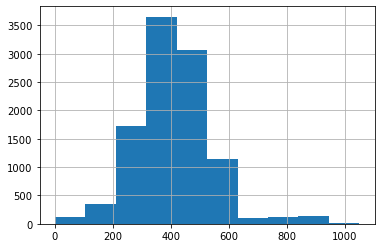

In [8]:
# Distribution of number of voter by each kalpi

votes_df["num_voters"].hist()

In [9]:
# The city with largest number of kalpi

votes_df.groupby("city").count().sort_values("kalpi_code", ascending=False)["kalpi_code"]

# votes_df['city'].value_counts()

city
ירושלים             681
תל אביב - יפו       680
חיפה                413
ראשון לציון         329
מעטפות חיצוניות     295
                   ... 
כרם בן זמרה           1
כרם יבנה (ישיבה)      1
כרם מהר"ל             1
כרם שלום              1
תרום                  1
Name: kalpi_code, Length: 1196, dtype: int64

In [10]:
# Largets fraction of disqualified?

votes_df["fraction_disqualified"] = votes_df["num_disqualified"] / votes_df["num_voters"]

votes_df.sort_values("fraction_disqualified", ascending=False).head(10)

,city,city_code,kalpi_code,num_voters,num_disqualified,final_num,fraction_disqualified
4114,ירושלים,3000,133,270,56,214,0.207407
6502,נצרת,7300,41,456,64,392,0.140351
3773,טירת כרמל,2100,18,357,43,314,0.120448
5477,מודיעין עילית,3797,12,480,54,426,0.112500
587,אשדוד,70,60,492,52,440,0.105691
589,אשדוד,70,62,332,35,297,0.105422
1661,בני ברק,6100,112,461,47,414,0.101952
5487,מודיעין עילית,3797,23,536,53,483,0.098881
1645,בני ברק,6100,96,316,31,285,0.098101
8991,רמלה,8500,7,355,34,321,0.095775


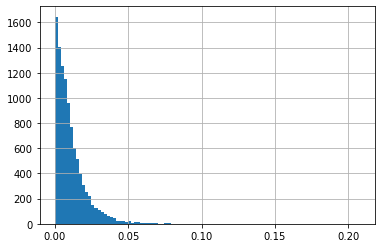

In [11]:
# Distribution of disqualified 

plt.figure()
votes_df["fraction_disqualified"].hist(bins=100)

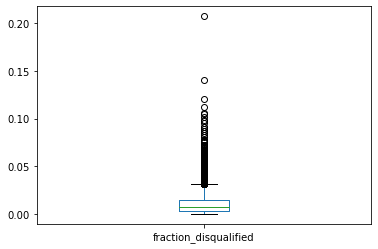

In [12]:
# Outliers for disqualified

plt.figure()
votes_df["fraction_disqualified"].plot(kind="box")

### Hypothesis Testing

**Cities which starting with letter 'א' have larger mean than all cities mean of disqualified votes?**

In [13]:
By_city_df = votes_df.groupby("city").sum()
By_city_df = By_city_df.drop(['city_code', 'kalpi_code'], axis=1)
By_city_df

,num_voters,num_disqualified,final_num,fraction_disqualified
city,,,,
אבו ג'ווייעד (שבט,313,7,306,0.092458
אבו גוש,2539,33,2506,0.076978
אבו סנאן,5798,52,5746,0.108915
אבו עבדון (שבט),37,1,36,0.027027
אבו קורינאת (שבט),759,7,752,0.032318
...,...,...,...,...
תקומה,335,4,331,0.011940
תקוע,1459,2,1457,0.004505
תראבין א-צאנע (שב,106,0,106,0.000000


In [14]:
By_city_df['num_disqualified'].describe()

count    1196.000000
mean       36.667224
std       198.566590
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max      3593.000000
Name: num_disqualified, dtype: float64

In [15]:
col = 'num_disqualified'
rows = By_city_df.index.str.startswith('א')
By_city_df.loc[rows, col]

city
אבו ג'ווייעד (שבט      7
אבו גוש               33
אבו סנאן              52
אבו עבדון (שבט)        1
אבו קורינאת (שבט)      7
                    ... 
אשל הנשיא              0
אשלים                  0
אשקלון               937
אשרת                   0
אשתאול                 2
Name: num_disqualified, Length: 119, dtype: int64

In [16]:
By_city_df.loc[rows, col].describe()

count     119.000000
mean       39.806723
std       200.448196
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max      1942.000000
Name: num_disqualified, dtype: float64

In [17]:
By_city_df.loc[rows, col].values

array([   7,   33,   52,    1,    7,    1,   11,   10,   15,    1,    1,
          2,    0,    3,    2,    0,    1,   36,    1,    0,    3,    0,
          2,    4,    0,    3,    0,    2,    2,    0,    1,  150,    1,
          6,    0,    0,  184,    0,    1,  265,   86,    8,    1,    1,
          4,    9,    0,   57,    0,    1,    3,    3,    0,    5,    9,
          7,    2,    2,   10,    1,    1,    3,  235,    0,    1,   38,
          0,    1,    2,    0,    0,    0,    0,    4,    0,    0,    0,
          5,    0,   17,    0,    1,    1,    8,    0,    1,  228,    1,
         12,    3,    6,    4,    2,    1,    0,    3,    1,    2,   39,
         25,    1,    7,    0,   14,    3,    1,    3,  159,    2, 1942,
          1,    0,    2,    1,    0,    0,  937,    0,    2], dtype=int64)

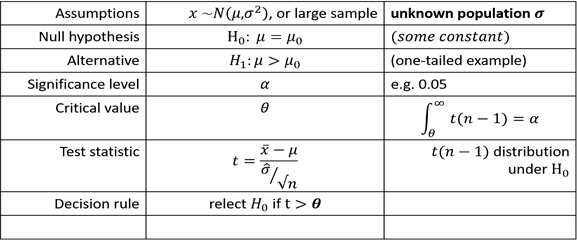

In [18]:
from scipy import stats
from scipy.stats import norm

alpha=0.05
n_sided = 1 # 1-sided test
t_crit = norm.ppf(1-alpha / n_sided)
print("Critical value is: ",t_crit) # 1.959963984540054

t_statistic, p_value = ttest_1samp(By_city_df.loc[rows, col].values, popmean=36.667224, alternative="greater")
print("t-statistic is: ", t_statistic)
print("p-value is: ", p_value)

Critical value is:  1.6448536269514722
t-statistic is:  0.17085655081059073
p-value is:  0.4323145936780066


Decison Rules:  

* Relect Hₒ if t > critical value ---> 0.17 < 1.66, hence we cannot relect the null hypothesis.

* Reject Hₒ if p-value = 0.0.8694 ≤ alpha = 0.05 ---> So we don't reject Hₒ.

In [19]:
import scipy.stats as st
import numpy as np

(lower_all, upper_all) = st.t.interval(alpha=0.95, df=len(By_city_df['num_disqualified'])-1, loc=np.mean(By_city_df['num_disqualified']), scale=st.sem(By_city_df['num_disqualified']))
(lower_start_with, upper_start_with) = st.t.interval(alpha=0.95, df=len(By_city_df.loc[rows, col].values)-1, loc=np.mean(By_city_df.loc[rows, col].values), scale=st.sem(By_city_df.loc[rows, col].values))

# sem - Std. error of the proportion (std / sqrt(n))

print(f'Confidence Interval 95% for all group: [{lower_all:.3f}, {upper_all:.3f}]')
print(f'Confidence Interval 95% for treatment group: [{lower_start_with:.3f}, {upper_start_with:.3f}]')

Confidence Interval 95% for all group: [25.402, 47.932]
Confidence Interval 95% for treatment group: [3.419, 76.194]


### Let's explore the election result on 2021

#### Load votes on 2021 election

In [20]:
votes_data = pd.read_excel(os.path.abspath("votes_2021_by_city.xlsx"), index_col=1)
votes_data.head()

,סמל ועדה,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ב,ג,ודעם,...,ק,קי,קך,קץ,ר,רנ,רף,רק,שס,ת
שם ישוב,,,,,,,,,,,,,,,,,,,,,
אבירים,6,1220,221,151,1,150,47,0,0,3,...,0,0,0,0,5,0,0,0,1,8
אדירים,5,113,234,180,0,180,1,7,4,0,...,0,0,0,0,2,0,0,0,61,6
אושה,8,278,382,276,0,276,72,7,0,3,...,0,0,0,0,1,0,0,0,0,15
אחווה,17,1157,183,145,0,145,14,4,0,0,...,0,0,0,0,0,0,0,0,2,8
איבים,17,338,138,40,0,40,0,4,0,0,...,0,0,1,0,0,0,0,0,1,0


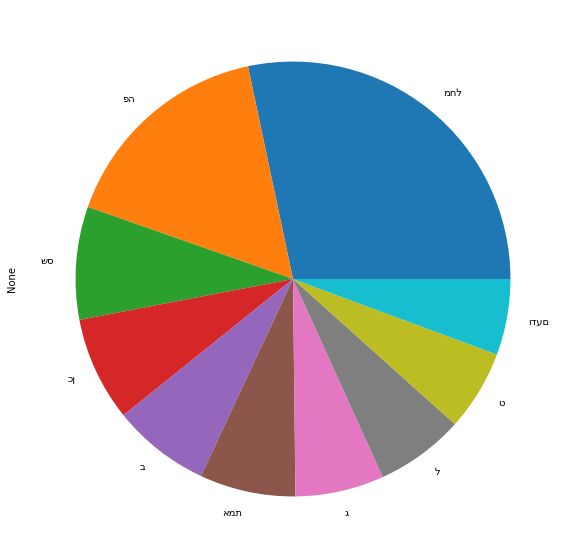

In [21]:
# Display 10 top parties who got most votes

per_party = votes_data.iloc[:, 6:].sum().sort_values(ascending=False)
per_party.head(10).plot(kind="pie", figsize=(10, 10))

#### Load info about cities in Israel

In [22]:
cities_data = pd.read_excel(os.path.abspath("cities.xlsx"), index_col=0)
cities_data.head()

,סמל יישוב,תעתיק,מחוז,נפה,אזור טבעי,מעמד מונציפאלי,שיוך מטרופוליני,דת יישוב,סך הכל אוכלוסייה 2019,יהודים ואחרים,...,שנת ייסוד,צורת יישוב שוטפת,השתייכות ארגונית,קואורדינטות,גובה ממוצע,ועדת תכנון,מרחב משטרה,שנה,שם יישוב באנגלית,אשכול רשויות מקומיות
שם יישוב,,,,,,,,,,,,,,,,,,,,,
אבו ג'ווייעד (שבט),967,ABU JUWEI'ID,6,62,623.0,NaN,NaN,3.0,NaN,NaN,...,NaN,460,NaN,2.040057e+09,NaN,699.0,15003711.0,2019,Abu Juway'ad,NaN
אבו גוש,472,ABU GHOSH,1,11,111.0,99.0,444.0,2.0,7699.0,88.0,...,NaN,280,NaN,2.105263e+09,686.0,152.0,10002475.0,2019,Abu Ghosh,NaN
אבו סנאן,473,ABU SINAN,2,24,245.0,99.0,NaN,2.0,14100.0,31.0,...,NaN,270,NaN,2.160776e+09,71.0,252.0,10004315.0,2019,Abu Sinan,NaN
אבו סריחאן (שבט),935,ABU SUREIHAN,6,62,623.0,NaN,NaN,3.0,NaN,NaN,...,NaN,460,NaN,1.865057e+09,NaN,699.0,10001937.0,2019,Abu Surayhan,NaN
אבו עבדון (שבט),958,ABU ABDUN,6,62,623.0,NaN,NaN,3.0,NaN,NaN,...,NaN,460,NaN,1.850058e+09,NaN,699.0,10001937.0,2019,Abu 'Abdun,NaN


In [23]:
cities_data.columns

Index(['סמל יישוב', 'תעתיק', 'מחוז', 'נפה', 'אזור טבעי', 'מעמד מונציפאלי',
       'שיוך מטרופוליני', 'דת יישוב', 'סך הכל אוכלוסייה 2019', 'יהודים ואחרים',
       'מזה: יהודים', 'ערבים', 'שנת ייסוד', 'צורת יישוב שוטפת',
       'השתייכות ארגונית', 'קואורדינטות', 'גובה ממוצע', 'ועדת תכנון',
       'מרחב משטרה', 'שנה', 'שם יישוב באנגלית', 'אשכול רשויות מקומיות'],
      dtype='object')

In [24]:
cities_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1483 entries, אבו ג'ווייעד (שבט) to תרום
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   סמל יישוב              1483 non-null   int64  
 1   תעתיק                  1319 non-null   object 
 2   מחוז                   1483 non-null   int64  
 3   נפה                    1483 non-null   int64  
 4   אזור טבעי              1334 non-null   float64
 5   מעמד מונציפאלי         1406 non-null   float64
 6   שיוך מטרופוליני        553 non-null    float64
 7   דת יישוב               1246 non-null   float64
 8   סך הכל אוכלוסייה 2019  1218 non-null   float64
 9   יהודים ואחרים          1191 non-null   float64
 10  מזה: יהודים            1162 non-null   float64
 11  ערבים                  541 non-null    float64
 12  שנת ייסוד              1089 non-null   object 
 13  צורת יישוב שוטפת       1483 non-null   int64  
 14  השתייכות ארגונית       826 non-null    float

#### Merge "votes_data" & "cities_data"

In [25]:
votes_and_city = votes_data.join(cities_data, how="inner")
votes_and_city.head()

,סמל ועדה,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ב,ג,ודעם,...,שנת ייסוד,צורת יישוב שוטפת,השתייכות ארגונית,קואורדינטות,גובה ממוצע,ועדת תכנון,מרחב משטרה,שנה,שם יישוב באנגלית,אשכול רשויות מקומיות
אבו גוש,2,472,4961,1994,47,1947,18,4,4,951,...,NaN,280,NaN,2.105263e+09,686.0,152.0,10002475.0,2019,Abu Ghosh,NaN
אבו סנאן,6,473,9705,5151,81,5070,22,2,1,2127,...,NaN,270,NaN,2.160776e+09,71.0,252.0,10004315.0,2019,Abu Sinan,NaN
אבו תלול,18,1375,1004,480,1,479,1,0,0,22,...,NaN,290,NaN,1.933457e+09,388.0,624.0,15003711.0,2019,Abu Tulul ...,610.0
אבטין,8,652,1876,658,5,653,3,0,1,165,...,NaN,290,NaN,2.109174e+09,47.0,301.0,10004207.0,2019,Ibtin,NaN
אבטליון,6,1275,316,231,0,231,48,11,0,2,...,1987,370,10.0,2.332475e+09,363.0,205.0,10004513.0,2019,Avtalyon,210.0


In [26]:
votes_and_city.columns

Index(['סמל ועדה', 'סמל ישוב', 'בזב', 'מצביעים', 'פסולים', 'כשרים', 'אמת', 'ב',
       'ג', 'ודעם', 'ז', 'זץ', 'ט', 'י', 'יז', 'ינ', 'יף', 'יק', 'יר', 'כ',
       'כך', 'כן', 'ל', 'מחל', 'מרצ', 'נ', 'ני', 'נר', 'עם', 'פה', 'ףז', 'צי',
       'צכ', 'צף', 'ץ', 'ק', 'קי', 'קך', 'קץ', 'ר', 'רנ', 'רף', 'רק', 'שס',
       'ת', 'סמל יישוב', 'תעתיק', 'מחוז', 'נפה', 'אזור טבעי', 'מעמד מונציפאלי',
       'שיוך מטרופוליני', 'דת יישוב', 'סך הכל אוכלוסייה 2019', 'יהודים ואחרים',
       'מזה: יהודים', 'ערבים', 'שנת ייסוד', 'צורת יישוב שוטפת',
       'השתייכות ארגונית', 'קואורדינטות', 'גובה ממוצע', 'ועדת תכנון',
       'מרחב משטרה', 'שנה', 'שם יישוב באנגלית', 'אשכול רשויות מקומיות'],
      dtype='object')

In [27]:
votes_and_city.shape

(1042, 67)

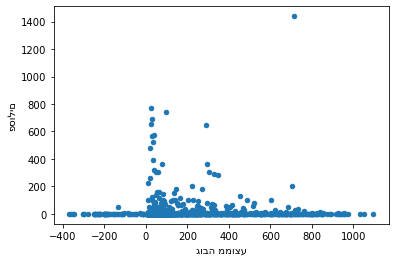

In [28]:
# The relationship between average height of city to number of disqulified votes

votes_and_city.plot(kind="scatter", x="גובה ממוצע", y="פסולים")

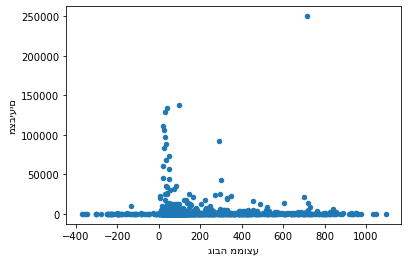

In [29]:
# The relationship between average height of city to number of voters

votes_and_city.plot(kind="scatter", x="גובה ממוצע", y="מצביעים")

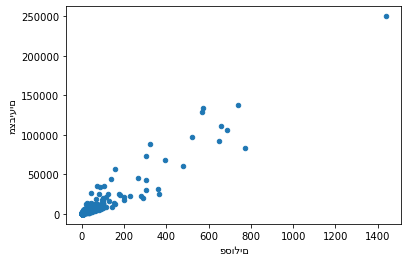

In [30]:
# The relationship between disqulified votes to number of voters# 

votes_and_city.plot(kind="scatter", x="פסולים", y="מצביעים")

#### Applied Linear Regression: predict city height from top 10 parties votes data

data: top 10 parties
label: Average cities height

In [31]:
top_parties = per_party.head(10).index
X = votes_and_city.loc[:, top_parties]
y = votes_and_city["גובה ממוצע"]

In [32]:
X

,מחל,פה,שס,כן,ב,אמת,ג,ל,ט,ודעם
אבו גוש,476,46,13,13,4,18,4,4,1,951
אבו סנאן,577,97,532,44,2,22,1,395,5,2127
אבו תלול,15,0,0,0,0,1,0,0,0,22
אבטין,59,8,2,0,0,3,1,1,0,165
אבטליון,17,74,0,15,11,48,0,7,1,2
...,...,...,...,...,...,...,...,...,...,...
תעוז,104,35,38,12,45,21,1,2,24,1
תפרח,51,2,133,1,7,0,652,0,33,0
תקומה,114,23,7,21,117,13,1,1,72,0
תקוע,326,34,22,27,590,33,12,29,374,1


In [33]:
# normalize rows -- percent votes instead of counst 

X_normalized = X.div(X.sum(axis=1), axis=0)
X_normalized

,מחל,פה,שס,כן,ב,אמת,ג,ל,ט,ודעם
אבו גוש,0.311111,0.030065,0.008497,0.008497,0.002614,0.011765,0.002614,0.002614,0.000654,0.621569
אבו סנאן,0.151762,0.025513,0.139926,0.011573,0.000526,0.005786,0.000263,0.103893,0.001315,0.559442
אבו תלול,0.394737,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.578947
אבטין,0.246862,0.033473,0.008368,0.000000,0.000000,0.012552,0.004184,0.004184,0.000000,0.690377
אבטליון,0.097143,0.422857,0.000000,0.085714,0.062857,0.274286,0.000000,0.040000,0.005714,0.011429
...,...,...,...,...,...,...,...,...,...,...
תעוז,0.367491,0.123675,0.134276,0.042403,0.159011,0.074205,0.003534,0.007067,0.084806,0.003534
תפרח,0.058020,0.002275,0.151308,0.001138,0.007964,0.000000,0.741752,0.000000,0.037543,0.000000
תקומה,0.308943,0.062331,0.018970,0.056911,0.317073,0.035230,0.002710,0.002710,0.195122,0.000000
תקוע,0.225138,0.023481,0.015193,0.018646,0.407459,0.022790,0.008287,0.020028,0.258287,0.000691


In [34]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, random_state=42)

# Create linear regression object
# Train the model using the training sets
reg = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred_linear_reg = reg.predict(X_test)

In [35]:
# print the coefficients
print(reg.intercept_)
print(reg.coef_)

280.95639165825327
[-122.33947606 -264.01625573 -154.47252179 -663.34624442  -68.86524034
  254.28270987   56.42068633  664.4293325   345.74805074  -47.84104109]


In [36]:
r2_score(y_test, y_pred_linear_reg)

0.13037612865816406

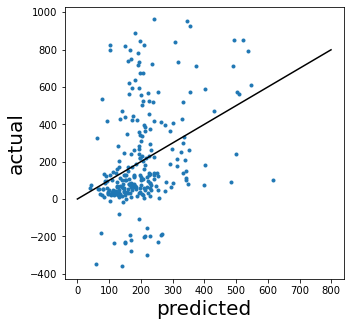

In [39]:
plt.figure(figsize=(5,5))
plt.plot(y_pred_linear_reg, y_test, '.')
plt.xlabel("predicted", fontsize=20)
plt.ylabel("actual", fontsize=20)
plt.plot(range(800), range(800), "-k")

### PCA for votes by city

In [40]:
k = 10
votes_data = pd.read_excel("votes_2021_by_city.xlsx", index_col=1)
per_party = votes_data.iloc[:, 6:].sum().sort_values(ascending=False) # only the parties data

top_parties = per_party.head(k).index # We want top 10 parties which got most votes
v = votes_data.loc[:, top_parties]
v_normalized = v.div(v.sum(axis=1), axis=0) # normalize data
v_normalized

,מחל,פה,שס,כן,ב,אמת,ג,ל,ט,ודעם
שם ישוב,,,,,,,,,,
אבירים,0.048544,0.262136,0.009709,0.155340,0.000000,0.456311,0.000000,0.019417,0.019417,0.029126
אדירים,0.491228,0.011696,0.356725,0.017544,0.040936,0.005848,0.023392,0.000000,0.052632,0.000000
אושה,0.101266,0.362869,0.000000,0.156118,0.029536,0.303797,0.000000,0.033755,0.000000,0.012658
אחווה,0.212598,0.291339,0.015748,0.283465,0.031496,0.110236,0.000000,0.023622,0.031496,0.000000
איבים,0.459459,0.000000,0.027027,0.135135,0.108108,0.000000,0.000000,0.000000,0.270270,0.000000
...,...,...,...,...,...,...,...,...,...,...
קורנית,0.085106,0.398936,0.000000,0.194149,0.047872,0.236702,0.000000,0.026596,0.007979,0.002660
שורשים,0.132780,0.336100,0.000000,0.157676,0.078838,0.248963,0.000000,0.029046,0.004149,0.012448
שכניה,0.041916,0.362275,0.002994,0.182635,0.050898,0.302395,0.000000,0.035928,0.011976,0.008982


In [47]:
# Get cities which numbers of votes is bigger than 5000

n = votes_data["מצביעים"]
print(n)
top_cities = votes_data[n > 5000].index 
top_cities

שם ישוב
אבירים                151
אדירים                180
אושה                  276
אחווה                 145
איבים                  40
                    ...  
קורנית                491
שורשים                290
שכניה                 445
שער אפרים             923
מעטפות חיצוניות    425512
Name: מצביעים, Length: 1215, dtype: int64


Index(['אשדוד', 'אשקלון', 'טבריה', 'שדרות', 'אופקים', 'אילת', 'באר שבע',
       'גני תקווה', 'דימונה', 'חדרה',
       ...
       'כוכב יאיר', 'כפר כנא', 'כפר קאסם', 'קרית אונו', 'כפר יונה', 'מיתר',
       'טייבה', 'טירה', 'קלנסווה', 'מעטפות חיצוניות'],
      dtype='object', name='שם ישוב', length=115)

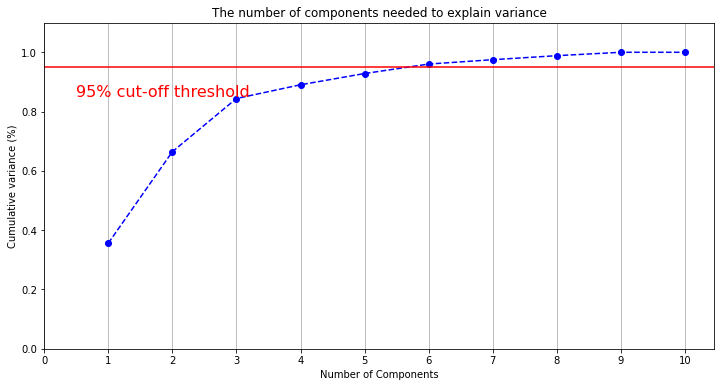

In [42]:
pca = PCA().fit(v_normalized)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In this case, to get 95% of variance explained  need 5 principal components.

In [44]:
pca_votes = PCA(n_components=5) # Number of components to keep
pca_votes.fit(v_normalized)

PCA(n_components=5)

In [48]:
city_loadings = pca_votes.transform(v_normalized)
city_loadings

array([[-0.21888381, -0.2707078 ,  0.04819447,  0.06047473, -0.09007592],
       [ 0.11216687,  0.32689458, -0.19860291,  0.16281303,  0.01062439],
       [-0.21707934, -0.21370584, -0.00380092,  0.00592436, -0.03080548],
       ...,
       [-0.23013269, -0.24026831,  0.04687938,  0.00206392, -0.00835671],
       [-0.05086824,  0.11184204, -0.12805854, -0.02388123,  0.00340128],
       [-0.00287465,  0.08608743, -0.02888798,  0.01847207,  0.03714316]])

In [49]:
pca_loadings_top = pd.DataFrame(city_loadings, index=v.index).loc[top_cities] # keep top cities after PCA transform
pca_loadings_top

,0,1,2,3,4
שם ישוב,,,,,
אשדוד,0.031687,0.160934,-0.099316,0.148832,0.089876
אשקלון,0.039376,0.223208,-0.152062,0.031342,0.005526
טבריה,0.074652,0.266027,-0.168763,0.132350,0.027561
שדרות,0.073387,0.283560,-0.083731,0.003239,0.026481
אופקים,0.079569,0.222004,-0.077619,0.225450,0.100867
...,...,...,...,...,...
מיתר,-0.075219,0.050953,-0.013697,-0.071849,0.056349
טייבה,0.811359,-0.477620,0.032771,-0.023863,0.004122
טירה,0.728355,-0.463412,0.026512,-0.029877,0.002499


### Clustring in PCA space

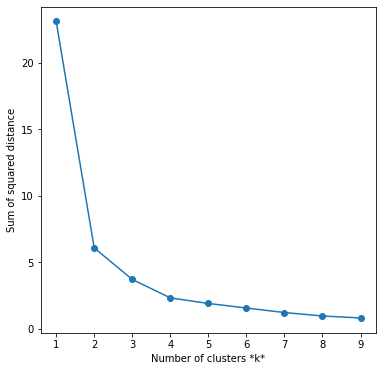

In [50]:
# Run the Kmeans algorithm and get the index of data points clusters - Elbow Method

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(pca_loadings_top.values[:, :n_components])
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [52]:
n_clusters = 3 # Chosen according to the elbow method
n_components = 5

In [57]:
kmeans = KMeans(n_clusters=n_clusters)
assignemnts = kmeans.fit_predict(pca_loadings_top.values[:, :n_components])
print(assignemnts)

[2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 1 2 2 0 2 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 1 2 2 2 0 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2 2
 2 2 1 1 1 2 1 2 2 1 2 2 1 2 2 1 1 2 1 2 2 1 2 2 1 2 1 1 2 2 2 2 1 1 2 2 2
 1 1 1 2]


['מודיעין עילית' 'אלעד' 'בית שמש' 'ביתר עילית' 'בני ברק' 'רכסים']


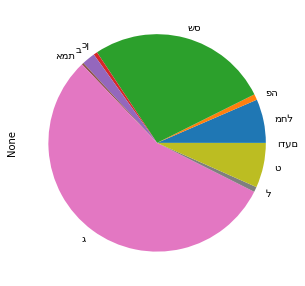

['אשדוד' 'אשקלון' 'טבריה' 'שדרות' 'אופקים' 'אילת' 'באר שבע' 'גני תקווה'
 'דימונה' 'חדרה' 'חיפה' 'לוד' 'מגאר' 'נתיבות' 'עפולה' 'ערד' 'פתח תקווה'
 'קרית אתא' 'קרית ביאליק' 'קרית גת' 'קרית מלאכי' 'ראשון לציון' 'רחובות'
 'אור עקיבא' 'אפרת' 'בנימינהגבעת עדה' 'בת ים' 'גבעת שמואל' 'הוד השרון'
 'ירושלים' 'כפר סבא' 'מבשרת ציון' 'מגדל העמק' 'מודיעיןמכביםרעות' 'צפת'
 'קרית ים' 'קרית מוצקין' 'ראש העין' 'רמלה' 'רעננה' 'אזור' 'חולון' 'יבנה'
 'יהודמונוסון' 'נס ציונה' 'נשר' 'פרדס חנהכרכור' 'קרית שמונה' 'רמת גן'
 'תל אביב  יפו' 'אבן יהודה' 'גבעת זאב' 'גבעתיים' 'גדרה' 'זכרון יעקב'
 'מעלותתרשיחא' 'נתניה' 'עכו' 'קדימהצורן' 'גן יבנה' 'ירכא' 'קרית טבעון'
 'קרית עקרון' 'שוהם' 'מזכרת בתיה' 'בית שאן' 'הרצליה' 'נוף הגליל'
 'רמת השרון' 'אור יהודה' 'אריאל' 'כרמיאל' 'מעלה אדומים' 'נהריה' 'תל מונד'
 'דאלית אלכרמל' 'טירת כרמל' 'באר יעקב' 'חריש' 'יקנעם עילית' 'כוכב יאיר'
 'קרית אונו' 'כפר יונה' 'מיתר' 'מעטפות חיצוניות']


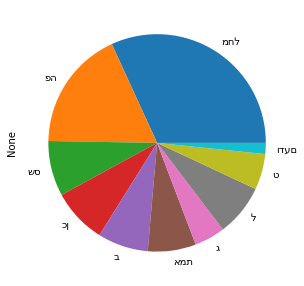

['ערערה' 'רהט' 'נצרת' 'גדיידהמכר' 'טמרה' 'כפר קרע' 'שפרעם' 'אבו סנאן'
 'כאבול' 'אום אלפחם' 'יפיע' 'דייר אלאסד' 'באקה אלגרביה' 'כפר מנדא'
 'מגד אלכרום' 'סחנין' 'דייר חנא' 'עראבה' 'ריינה' 'כפר כנא' 'כפר קאסם'
 'טייבה' 'טירה' 'קלנסווה']


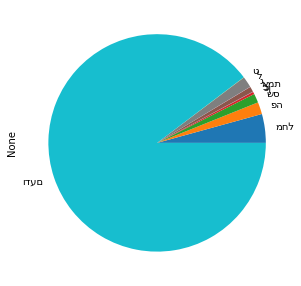

In [56]:
for i, group in pd.Series(assignemnts, index=pca_loadings_top.index).groupby(assignemnts):
    print("="*80)
    print(group.index.values)
    v.loc[group.index.values].sum().plot(kind="pie", figsize=(5, 5))
    plt.show()